
========================= Running Experiment on: mujoco/halfcheetah/expert-v0 =========================
--- Run 1/10, Seed 416057 ---
--- Run 2/10, Seed 206349 ---
--- Run 3/10, Seed 428492 ---
--- Run 4/10, Seed 232911 ---
--- Run 5/10, Seed 292383 ---
--- Run 6/10, Seed 739149 ---
--- Run 7/10, Seed 160516 ---
--- Run 8/10, Seed 65369 ---
--- Run 9/10, Seed 630717 ---
--- Run 10/10, Seed 822870 ---

============================== Plotting Results ==============================


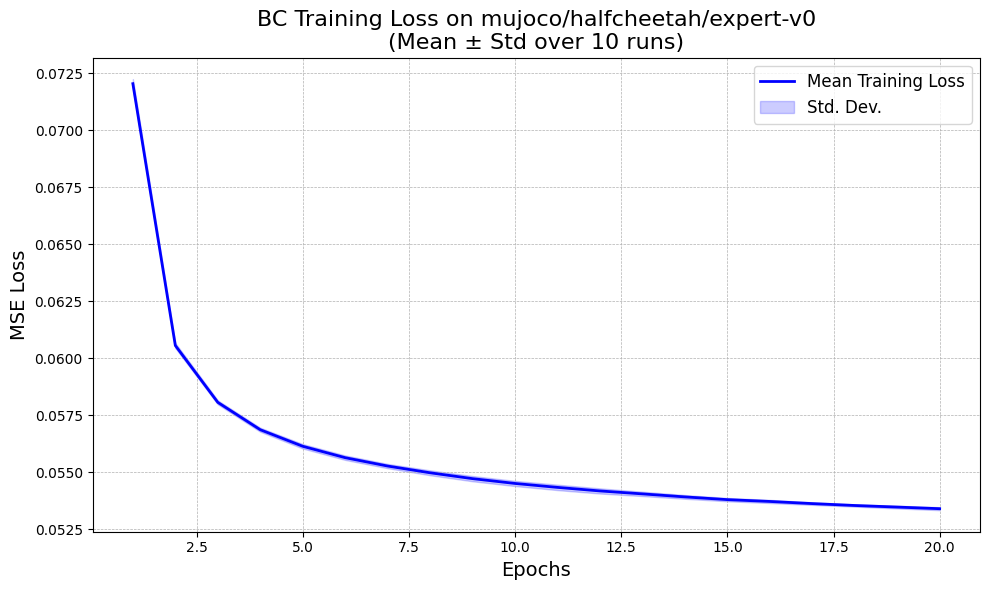

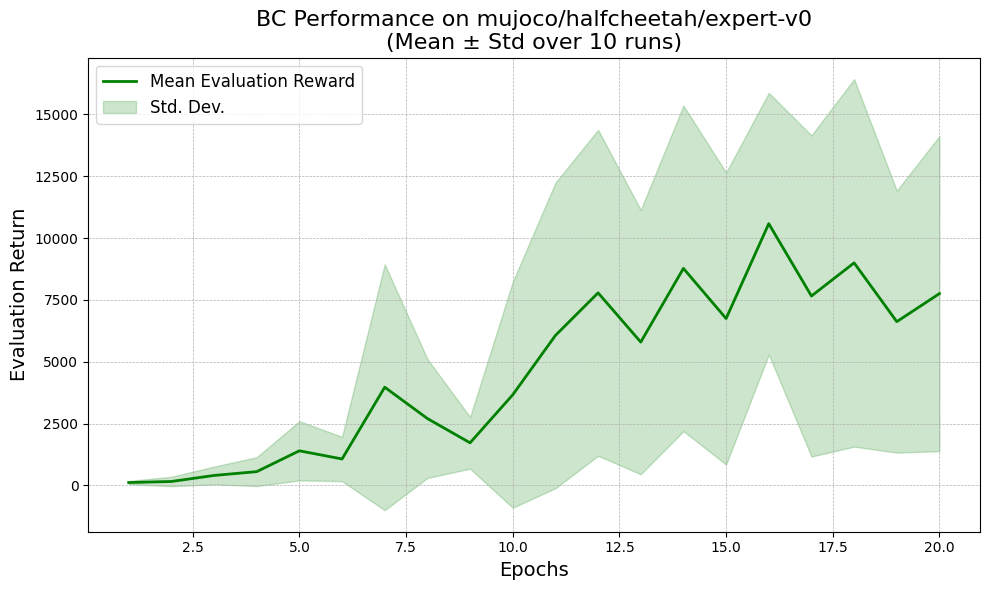


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/halfcheetah/expert-v0             | 7758.72 ± 6371.49


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/halfcheetah/expert-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/pusher/expert-v0 =========================
--- Run 1/10, Seed 618830 ---
--- Run 2/10, Seed 754138 ---
--- Run 3/10, Seed 338925 ---
--- Run 4/10, Seed 612701 ---
--- Run 5/10, Seed 965495 ---
--- Run 6/10, Seed 575429 ---
--- Run 7/10, Seed 532085 ---
--- Run 8/10, Seed 970861 ---
--- Run 9/10, Seed 483538 ---
--- Run 10/10, Seed 975374 ---

========================= Running Experiment on: mujoco/reacher/expert-v0 =========================
--- Run 1/10, Seed 333273 ---
--- Run 2/10, Seed 704270 ---
--- Run 3/10, Seed 463907 ---
--- Run 4/10, Seed 627698 ---
--- Run 5/10, Seed 845455 ---
--- Run 6/10, Seed 896412 ---
--- Run 7/10, Seed 489537 ---
--- Run 8/10, Seed 898776 ---
--- Run 9/10, Seed 664623 ---
--- Run 10/10, Seed 509924 ---

========================= Running Experiment on: mujoco/swimmer/expert-v0 =========================
--- Run 1/10, Seed 515561 ---
--- Run 2/10, Seed 563045 ---
--- Run 3/10, Seed 144087 ---
--- Ru

C:\Users\Wwmdp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching 2 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.70s/it]
C:\Users\Wwmdp\AppData\Local\Programs\Python\Python313\Lib\site-packages\minari\dataset\minari_dataset.py:204: UserWarning: Installed mujoco version 3.3.5 does not meet the requirement ==3.2.3.
We recommend to install the required version with `pip install "mujoco==3.2.3"`
  warnings.warn(



Dataset mujoco/walker2d/expert-v0 downloaded to C:\Users\Wwmdp\.minari\datasets\mujoco\walker2d\expert-v0
--- Run 2/10, Seed 937226 ---
--- Run 3/10, Seed 832481 ---
--- Run 4/10, Seed 870717 ---
--- Run 5/10, Seed 167340 ---
--- Run 6/10, Seed 762448 ---
--- Run 7/10, Seed 41156 ---
--- Run 8/10, Seed 759654 ---
--- Run 9/10, Seed 136082 ---
--- Run 10/10, Seed 606217 ---

========================= Running Experiment on: mujoco/inverteddoublependulum/expert-v0 =========================
--- Run 1/10, Seed 478762 ---
--- Run 2/10, Seed 309992 ---
--- Run 3/10, Seed 894426 ---
--- Run 4/10, Seed 729715 ---
--- Run 5/10, Seed 824251 ---
--- Run 6/10, Seed 974218 ---
--- Run 7/10, Seed 618765 ---
--- Run 8/10, Seed 51174 ---
--- Run 9/10, Seed 739683 ---
--- Run 10/10, Seed 198542 ---

========================= Running Experiment on: mujoco/hopper/expert-v0 =========================
--- Run 1/10, Seed 183006 ---
--- Run 2/10, Seed 267700 ---
--- Run 3/10, Seed 451554 ---
--- Run 4/10, See

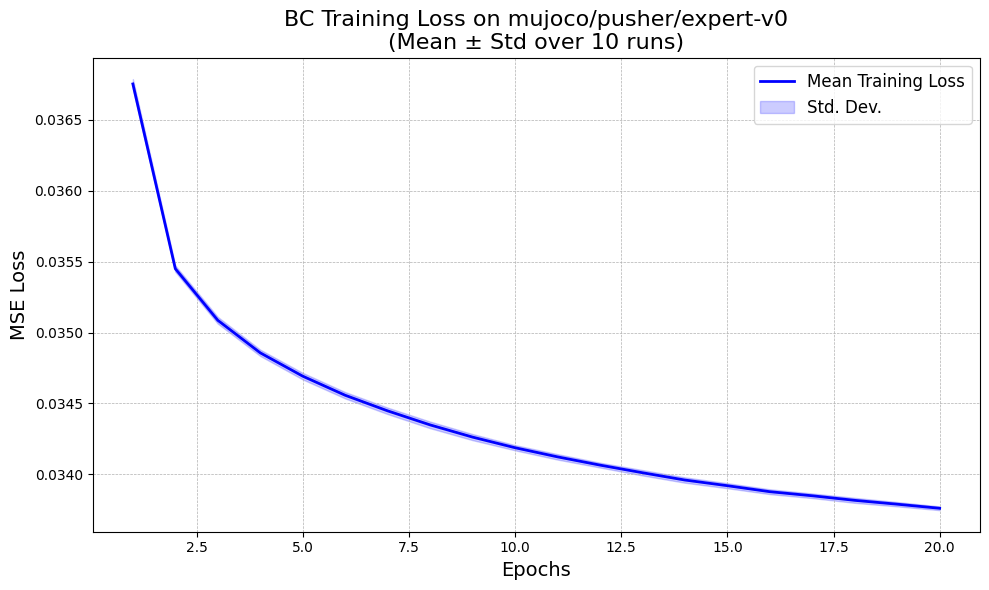

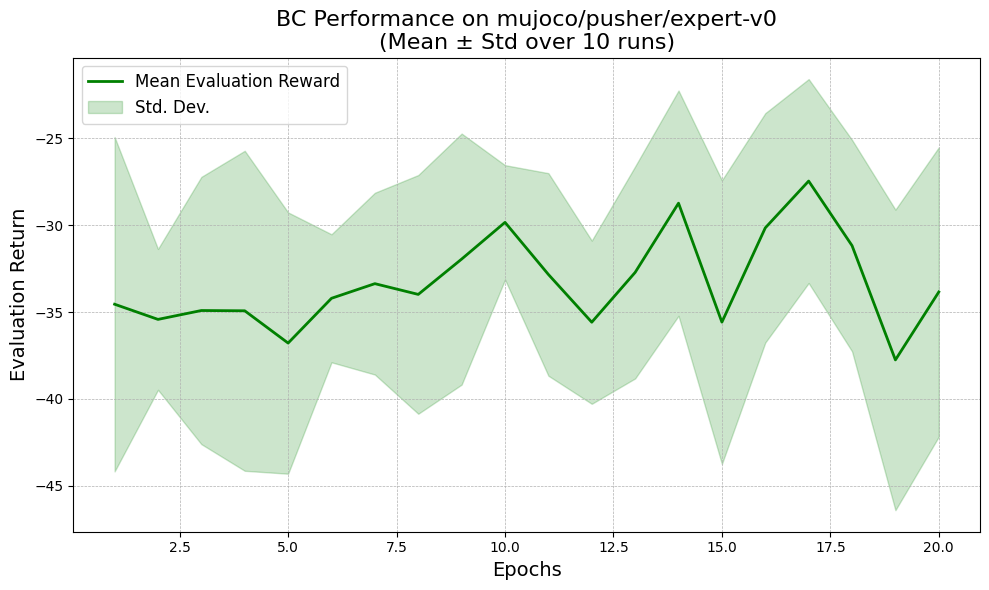

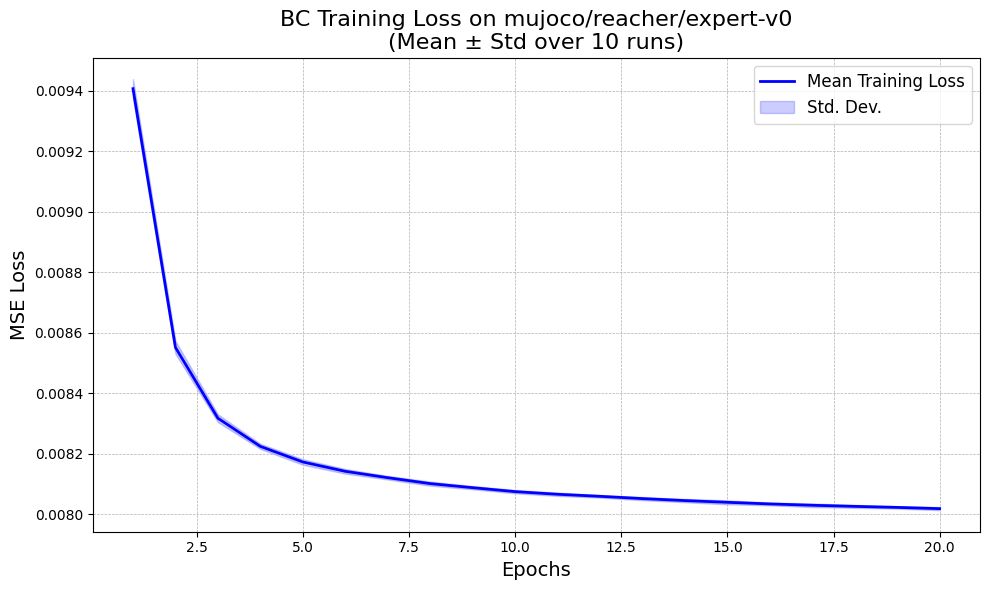

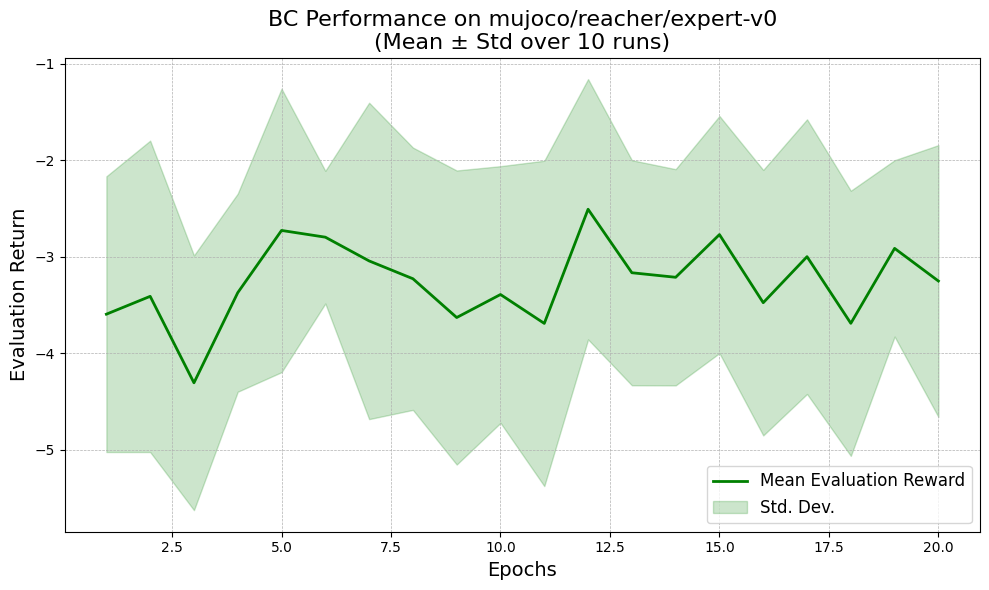

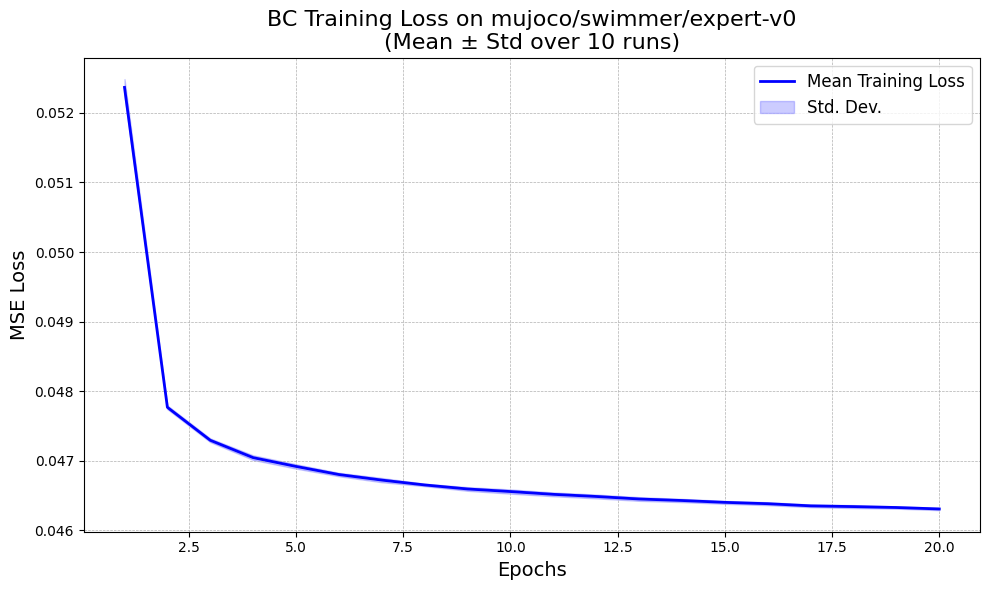

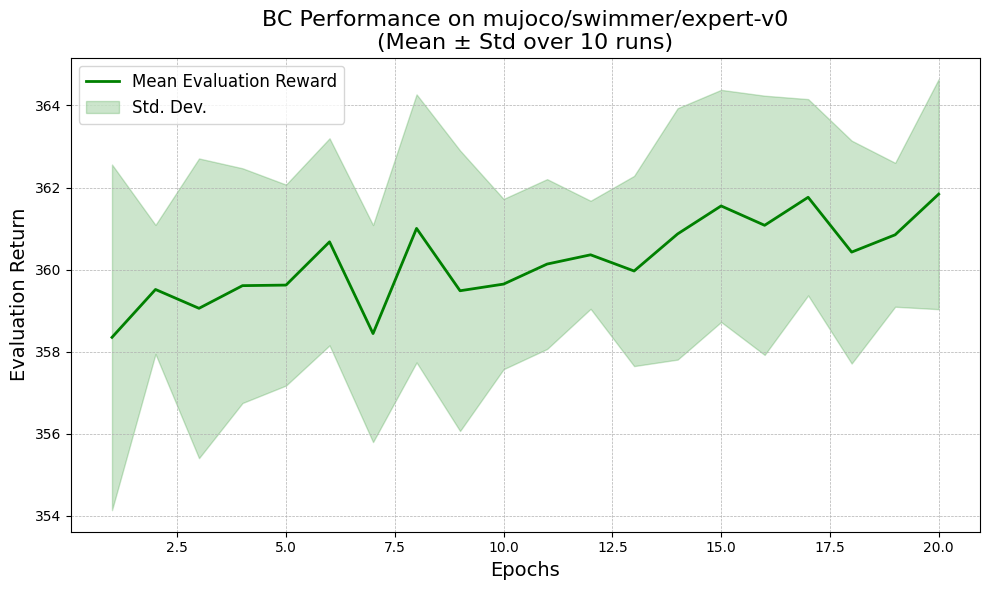

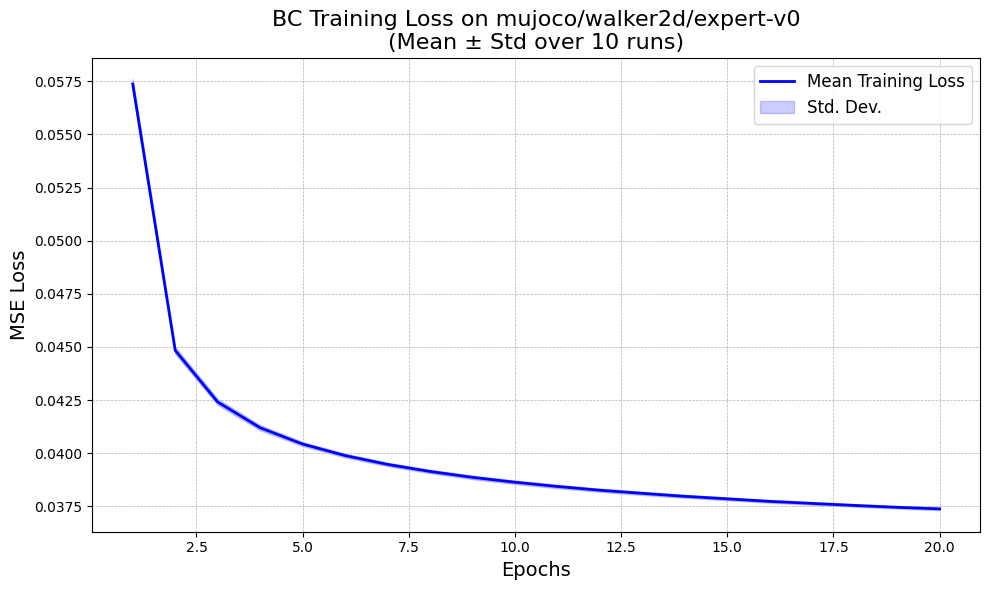

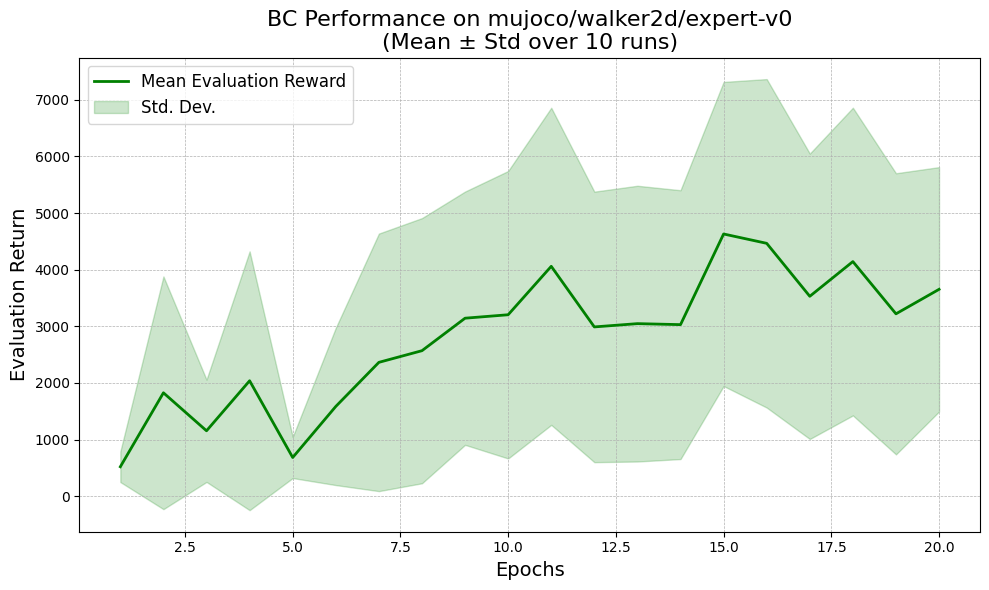

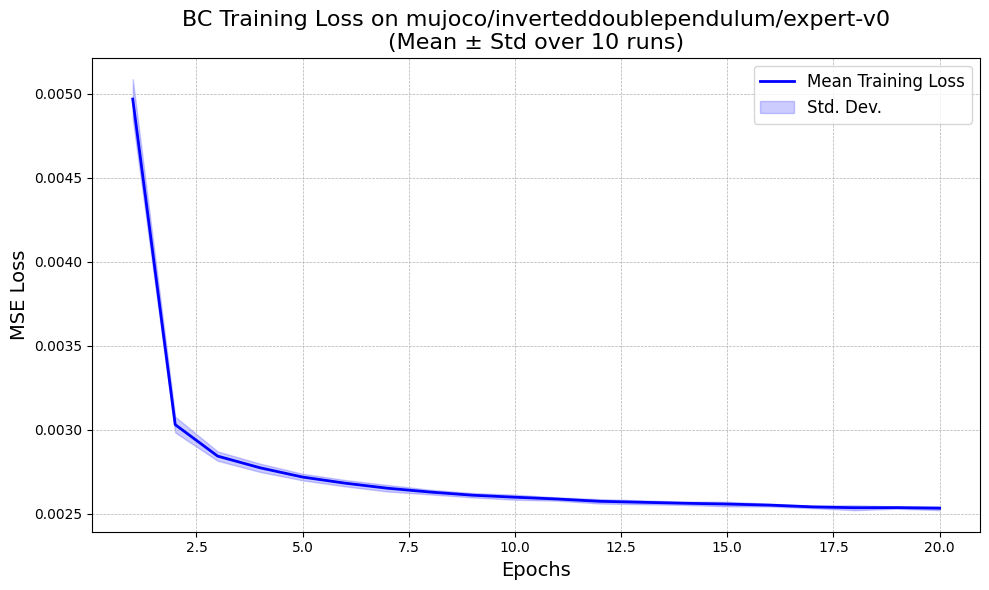

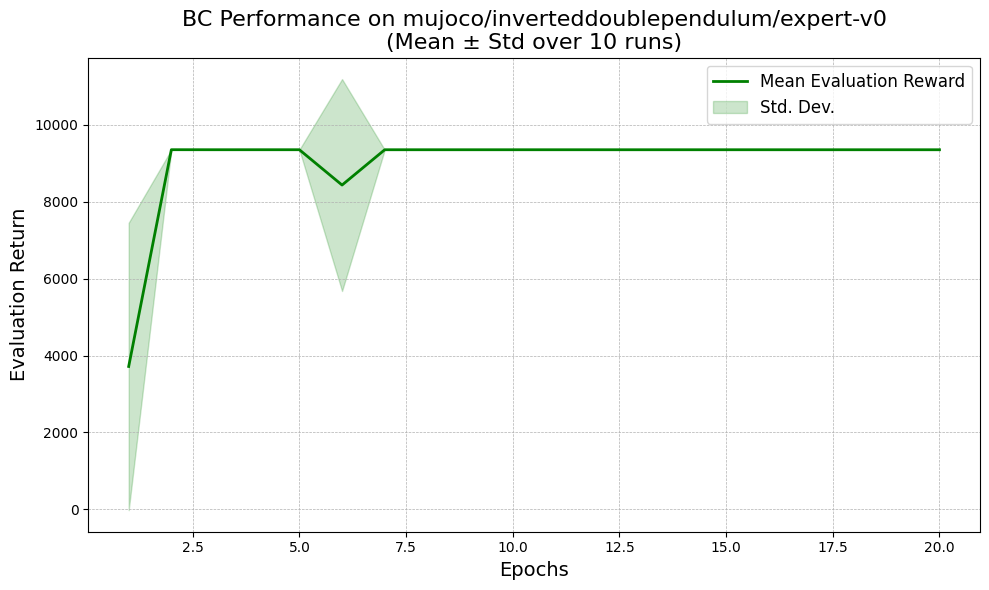

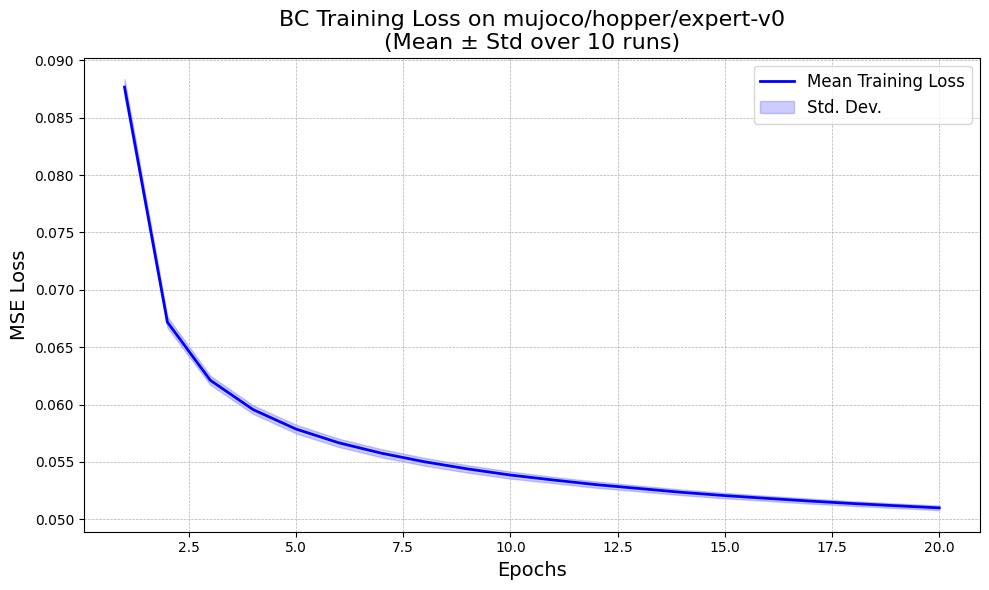

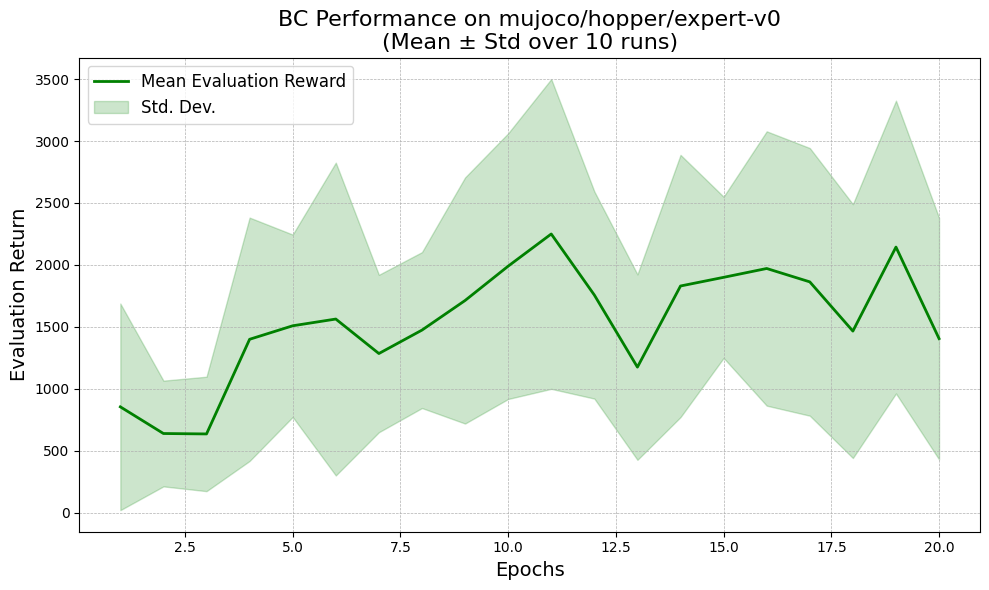

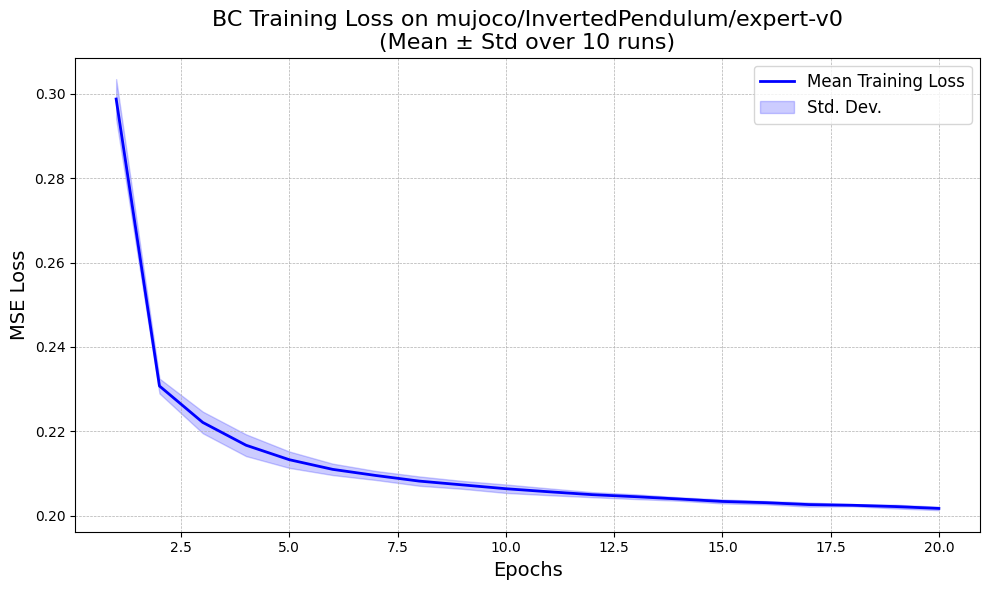

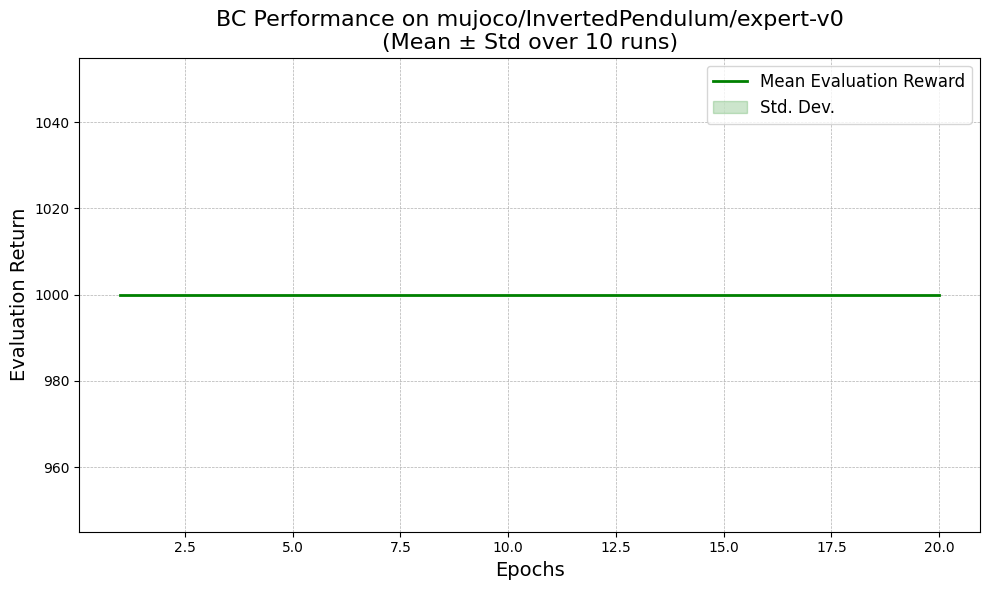


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/pusher/expert-v0                  | -33.84 ± 8.32
mujoco/reacher/expert-v0                 | -3.25 ± 1.41
mujoco/swimmer/expert-v0                 | 361.84 ± 2.80
mujoco/walker2d/expert-v0                | 3653.50 ± 2158.44
mujoco/inverteddoublependulum/expert-v0  | 9355.87 ± 0.25
mujoco/hopper/expert-v0                  | 1404.84 ± 975.21
mujoco/InvertedPendulum/expert-v0        | 1000.00 ± 0.00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/pusher/expert-v0",
        "mujoco/reacher/expert-v0",
        "mujoco/swimmer/expert-v0",
        "mujoco/walker2d/expert-v0",
        "mujoco/inverteddoublependulum/expert-v0",
        "mujoco/hopper/expert-v0",
        "mujoco/InvertedPendulum/expert-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/pusher/medium-v0 =========================
--- Run 1/10, Seed 84920 ---
--- Run 2/10, Seed 13590 ---
--- Run 3/10, Seed 732076 ---
--- Run 4/10, Seed 228383 ---
--- Run 5/10, Seed 209123 ---
--- Run 6/10, Seed 828082 ---
--- Run 7/10, Seed 435943 ---
--- Run 8/10, Seed 155252 ---
--- Run 9/10, Seed 789674 ---
--- Run 10/10, Seed 161548 ---

============================== Plotting Results ==============================


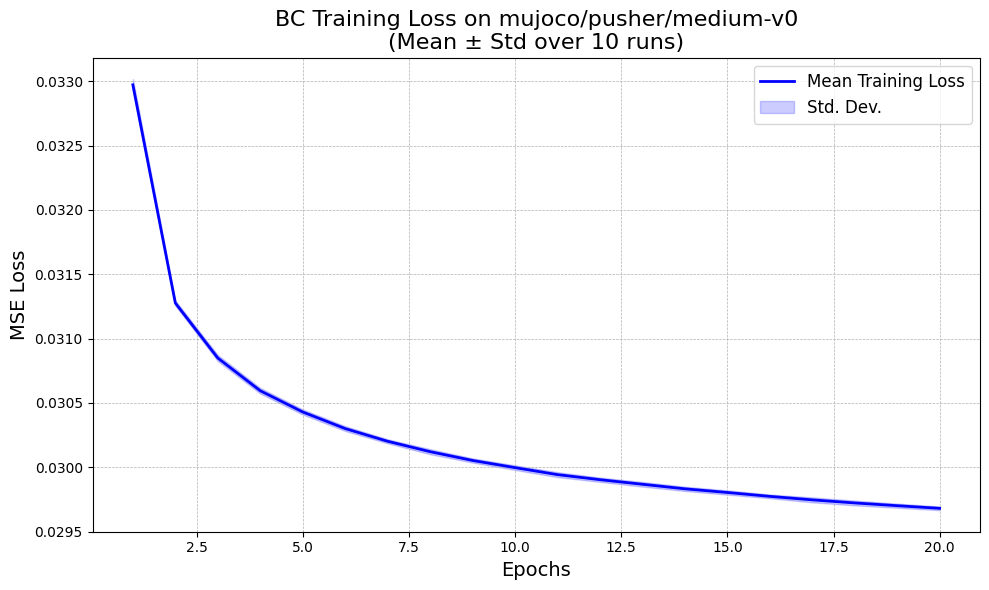

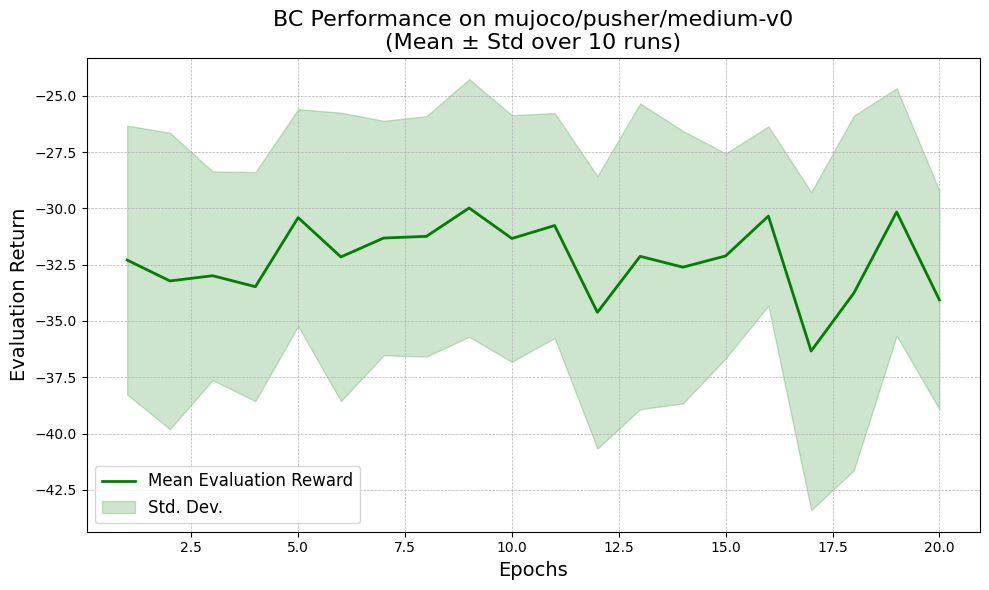


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/pusher/medium-v0                  | -34.06 ± 4.85


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/pusher/medium-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/swimmer/medium-v0 =========================
--- Run 1/10, Seed 855631 ---


C:\Users\Wwmdp\AppData\Local\Programs\Python\Python313\Lib\site-packages\minari\dataset\minari_dataset.py:204: UserWarning: Installed mujoco version 3.3.5 does not meet the requirement ==3.2.3.
We recommend to install the required version with `pip install "mujoco==3.2.3"`
  warnings.warn(


--- Run 2/10, Seed 125807 ---


C:\Users\Wwmdp\AppData\Local\Programs\Python\Python313\Lib\site-packages\minari\dataset\minari_dataset.py:204: UserWarning: Installed mujoco version 3.3.5 does not meet the requirement ==3.2.3.
We recommend to install the required version with `pip install "mujoco==3.2.3"`
  warnings.warn(


--- Run 3/10, Seed 457625 ---
--- Run 4/10, Seed 695946 ---
--- Run 5/10, Seed 214201 ---
--- Run 6/10, Seed 375255 ---
--- Run 7/10, Seed 149041 ---
--- Run 8/10, Seed 464192 ---
--- Run 9/10, Seed 36239 ---
--- Run 10/10, Seed 38627 ---

============================== Plotting Results ==============================


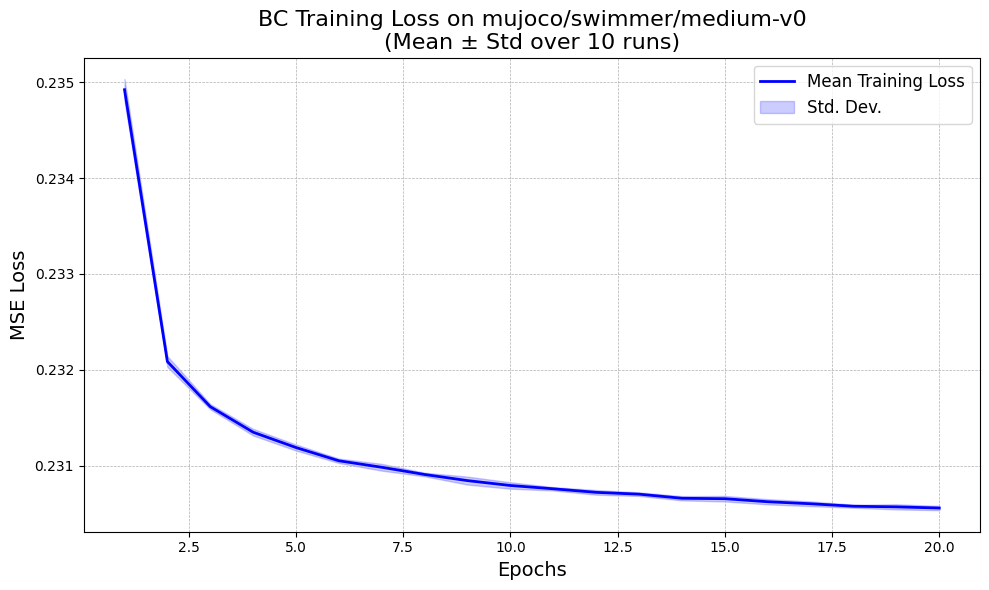

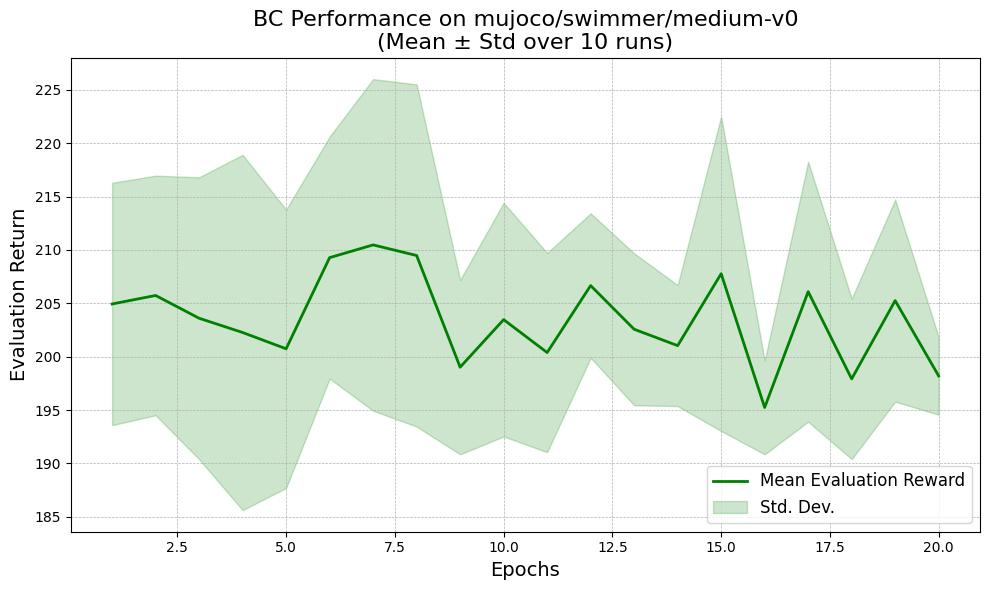


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/swimmer/medium-v0                 | 198.20 ± 3.64


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/swimmer/medium-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/walker2d/medium-v0 =========================
--- Run 1/10, Seed 85603 ---


C:\Users\Wwmdp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching 2 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.41s/it]
C:\Users\Wwmdp\AppData\Local\Programs\Python\Python313\Lib\site-packages\minari\dataset\minari_dataset.py:204: UserWarning: Installed mujoco version 3.3.5 does not meet the requirement ==3.2.3.
We recommend to install the required version with `pip install "mujoco==3.2.3"`
  warnings.warn(



Dataset mujoco/walker2d/medium-v0 downloaded to C:\Users\Wwmdp\.minari\datasets\mujoco\walker2d\medium-v0
--- Run 2/10, Seed 952999 ---
--- Run 3/10, Seed 906662 ---
--- Run 4/10, Seed 495650 ---
--- Run 5/10, Seed 28225 ---
--- Run 6/10, Seed 4575 ---
--- Run 7/10, Seed 210538 ---
--- Run 8/10, Seed 506770 ---
--- Run 9/10, Seed 861394 ---
--- Run 10/10, Seed 228776 ---

============================== Plotting Results ==============================


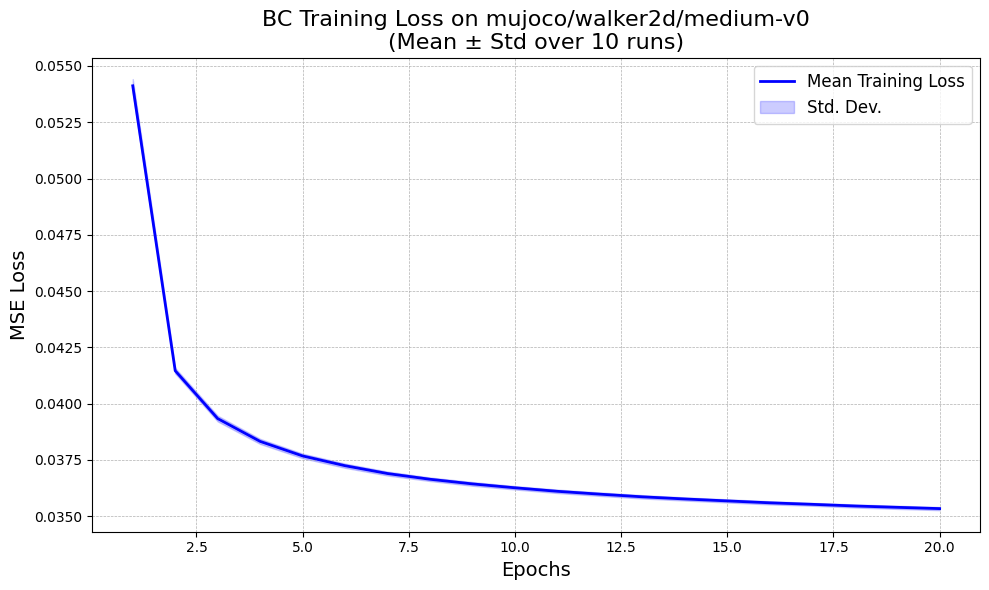

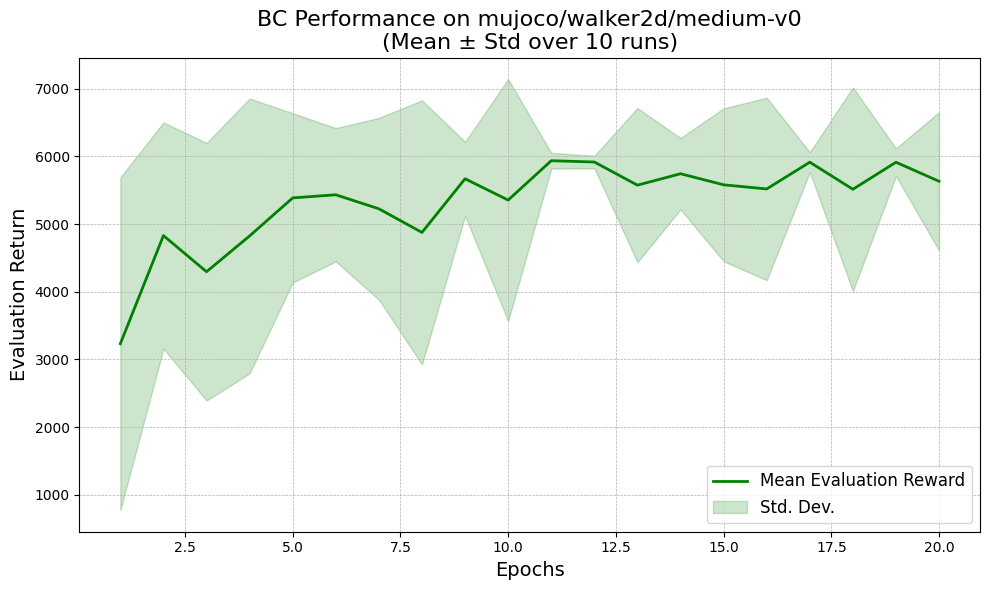


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/walker2d/medium-v0                | 5631.58 ± 1022.68


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/walker2d/medium-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/invertedpendulum/medium-v0 =========================
--- Run 1/10, Seed 279963 ---
--- Run 2/10, Seed 175320 ---
--- Run 3/10, Seed 214268 ---
--- Run 4/10, Seed 595167 ---
--- Run 5/10, Seed 54543 ---
--- Run 6/10, Seed 169807 ---
--- Run 7/10, Seed 438109 ---
--- Run 8/10, Seed 818050 ---
--- Run 9/10, Seed 68798 ---
--- Run 10/10, Seed 135071 ---

============================== Plotting Results ==============================


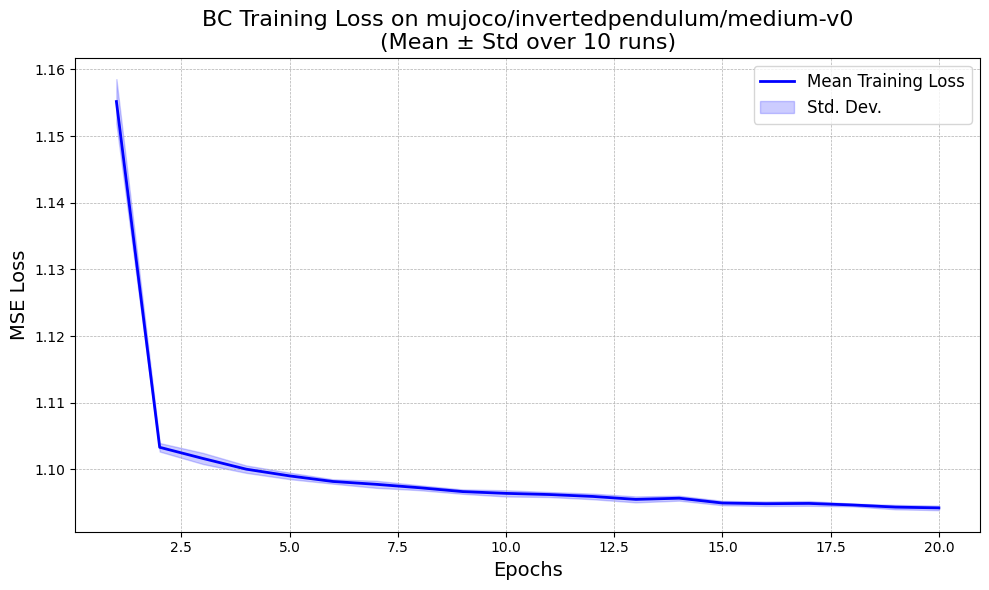

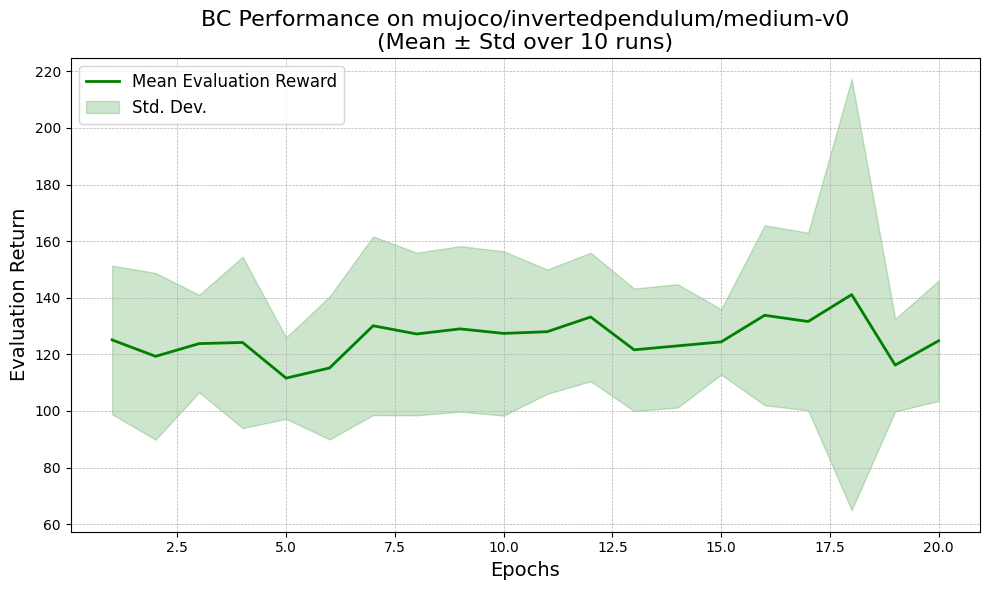


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/invertedpendulum/medium-v0        | 124.80 ± 21.27


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/invertedpendulum/medium-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/hopper/medium-v0 =========================
--- Run 1/10, Seed 254339 ---
--- Run 2/10, Seed 441061 ---
--- Run 3/10, Seed 156862 ---
--- Run 4/10, Seed 386619 ---
--- Run 5/10, Seed 980941 ---
--- Run 6/10, Seed 857656 ---
--- Run 7/10, Seed 730178 ---
--- Run 8/10, Seed 282994 ---
--- Run 9/10, Seed 319358 ---
--- Run 10/10, Seed 530635 ---

============================== Plotting Results ==============================


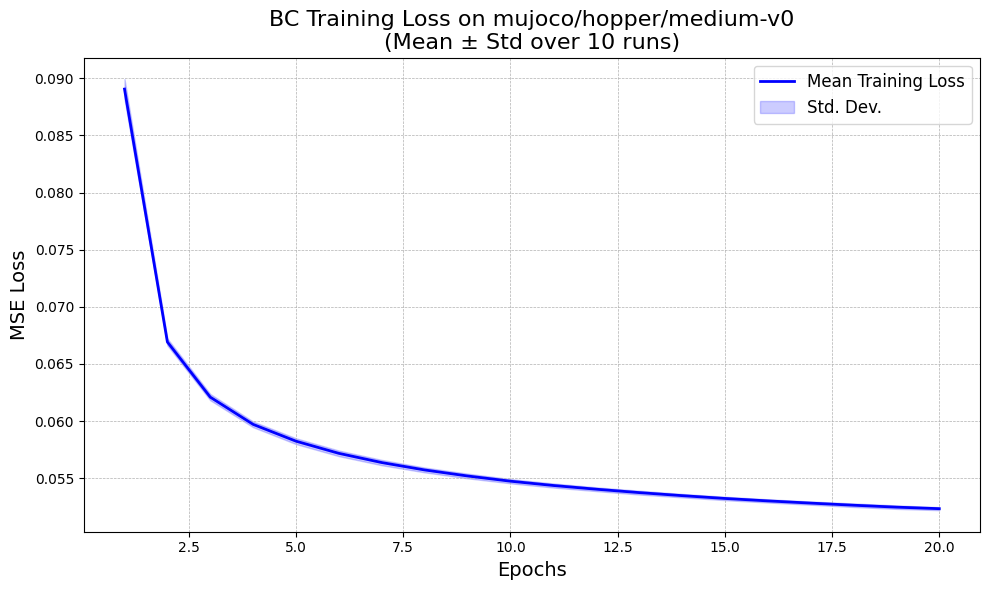

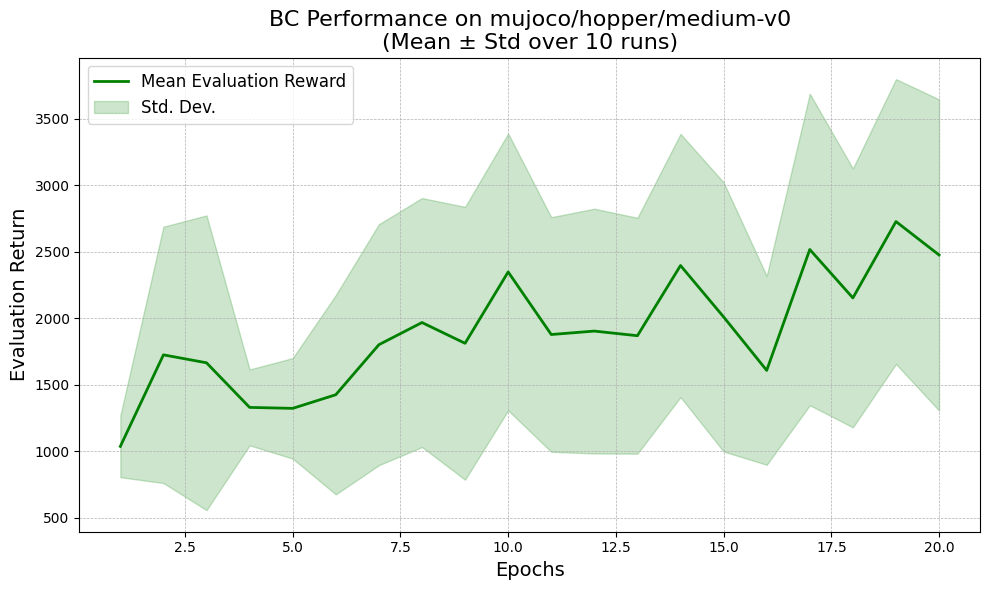


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/hopper/medium-v0                  | 2475.25 ± 1168.88


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/hopper/medium-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/inverteddoublependulum/medium-v0 =========================
--- Run 1/10, Seed 461018 ---
--- Run 2/10, Seed 142175 ---
--- Run 3/10, Seed 189145 ---
--- Run 4/10, Seed 795972 ---
--- Run 5/10, Seed 420674 ---
--- Run 6/10, Seed 872099 ---
--- Run 7/10, Seed 910302 ---
--- Run 8/10, Seed 436094 ---
--- Run 9/10, Seed 464373 ---
--- Run 10/10, Seed 873438 ---

============================== Plotting Results ==============================


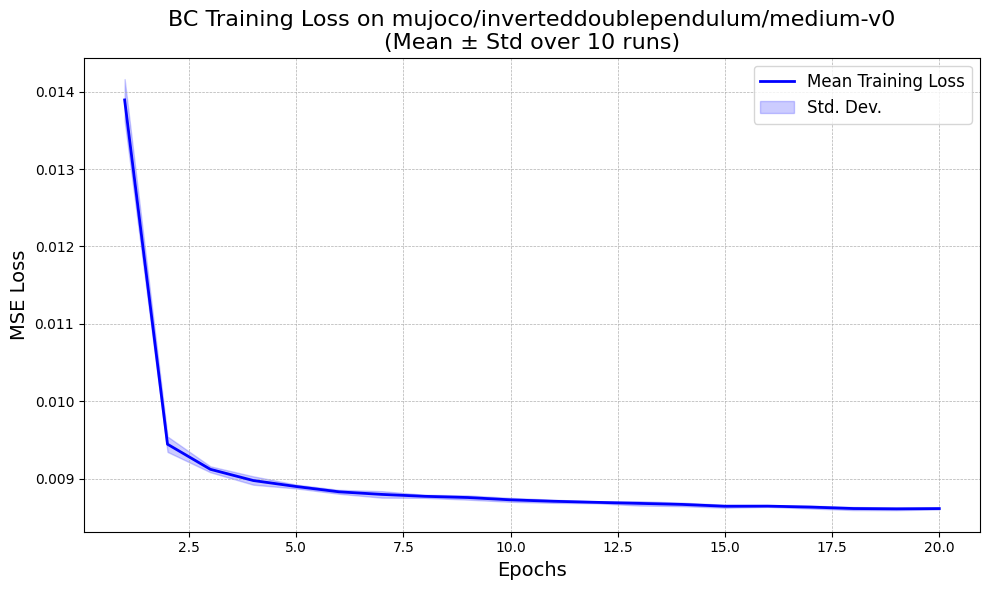

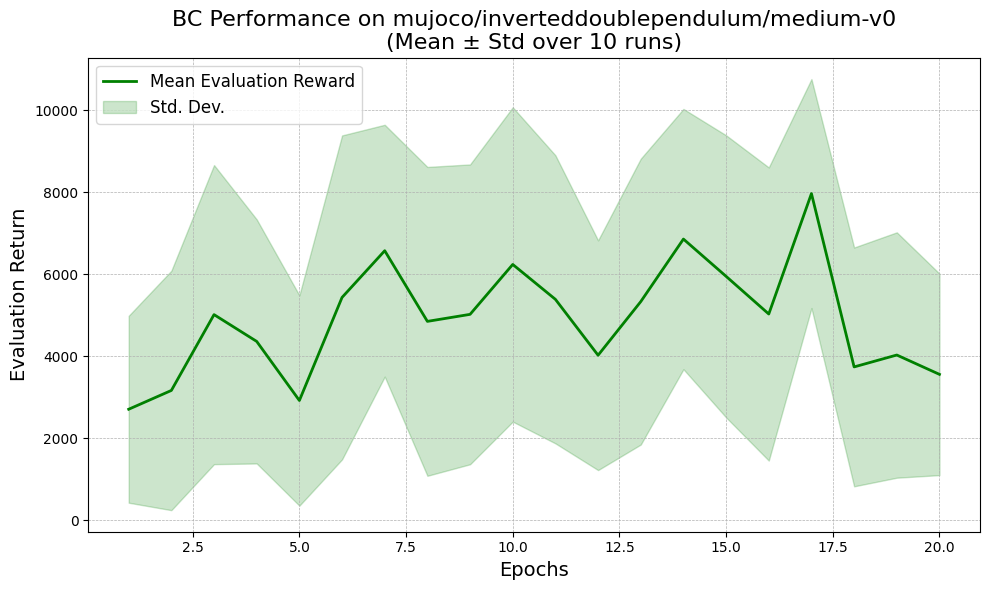


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/inverteddoublependulum/medium-v0  | 3562.46 ± 2457.52


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/inverteddoublependulum/medium-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")



========================= Running Experiment on: mujoco/halfcheetah/medium-v0 =========================
--- Run 1/10, Seed 448557 ---
--- Run 2/10, Seed 524276 ---
--- Run 3/10, Seed 865210 ---
--- Run 4/10, Seed 241122 ---
--- Run 5/10, Seed 495956 ---
--- Run 6/10, Seed 400527 ---
--- Run 7/10, Seed 374513 ---
--- Run 8/10, Seed 461092 ---
--- Run 9/10, Seed 641220 ---
--- Run 10/10, Seed 130966 ---

============================== Plotting Results ==============================


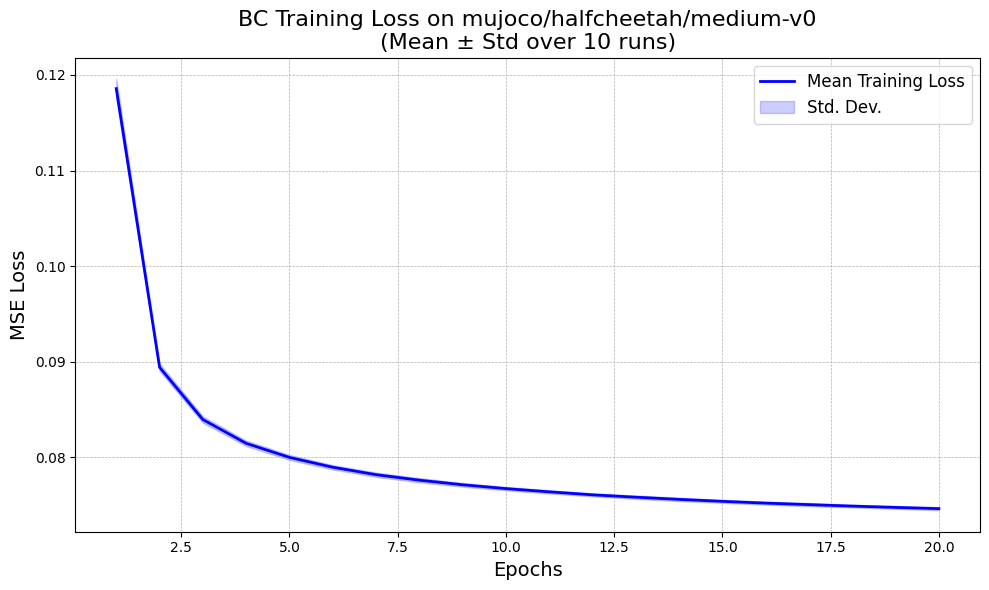

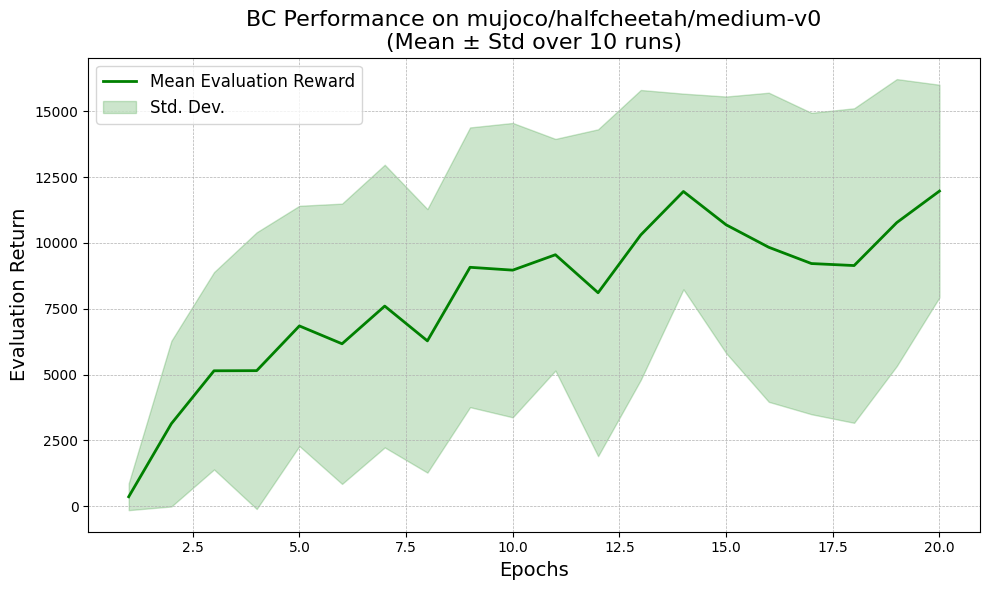


========================= Final Performance Summary =========================
Dataset                                  | Reward (Mean ± Std)
--------------------------------------------------------------
mujoco/halfcheetah/medium-v0             | 11972.09 ± 4037.10


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import minari
import random

# ---------------- Small Policy Network ----------------
class BCPolicySmall(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )
    def forward(self, x):
        return self.net(x)


# ---------------- Training Loop with per-epoch evaluation ----------------
def train_bc(dataset_name, num_epochs, batch_size, learning_rate, seed):
    # Reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Load dataset and env
    dataset = minari.load_dataset(dataset_name, download=True)
    env = dataset.recover_environment()
    env.reset(seed=seed)
    if hasattr(env, "action_space"):
        env.action_space.seed(seed)
    if hasattr(env, "observation_space"):
        env.observation_space.seed(seed)

    # Prepare offline data
    episodes = dataset.sample_episodes(dataset.total_episodes)
    obs_list, act_list = [], []
    for ep in episodes:
        obs_list.append(ep.observations[:-1])
        act_list.append(ep.actions)
    observations = torch.tensor(np.concatenate(obs_list, axis=0), dtype=torch.float32)
    actions = torch.tensor(np.concatenate(act_list, axis=0), dtype=torch.float32)
    tensor_dataset = TensorDataset(observations, actions)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    # Init policy + optimizer
    policy = BCPolicySmall(obs_dim=observations.shape[1], act_dim=actions.shape[1])
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Logs
    loss_history = []
    reward_history = []

    for epoch in range(num_epochs):
        # ---- Train for one epoch ----
        epoch_loss = 0
        for obs_batch, act_batch in loader:
            pred = policy(obs_batch)
            loss = loss_fn(pred, act_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * obs_batch.size(0)
        epoch_loss /= len(tensor_dataset)
        loss_history.append(epoch_loss)

        # ---- Evaluate after each epoch ----
        obs, _ = env.reset(seed=seed + epoch)  # vary seed per eval
        done = False
        total_reward = 0
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            action = policy(obs_tensor).detach().numpy()[0]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward
        reward_history.append(total_reward)

    return loss_history, reward_history


# ---------------- Main Experiment ----------------
if __name__ == "__main__":
    NUM_RUNS = 10         # fewer runs for speed
    NUM_EPOCHS = 20      # you can increase later
    BATCH_SIZE = 64
    LR = 1e-3
    DATASET_NAMES = [
        "mujoco/halfcheetah/medium-v0",
    ]

    all_results = {}

    for dataset in DATASET_NAMES:
        print(f"\n{'='*25} Running Experiment on: {dataset} {'='*25}")
        run_rewards, run_losses = [], []

        for i in range(NUM_RUNS):
            current_seed = np.random.randint(0, 1_000_000)
            print(f"--- Run {i+1}/{NUM_RUNS}, Seed {current_seed} ---")
            losses, rewards = train_bc(dataset, NUM_EPOCHS, BATCH_SIZE, LR, current_seed)
            run_rewards.append(rewards)
            run_losses.append(losses)

        run_rewards = np.array(run_rewards)
        run_losses = np.array(run_losses)

        all_results[dataset] = {
            "losses_all_runs": run_losses,
            "rewards_all_runs": run_rewards,
            "loss_mean": np.mean(run_losses, axis=0),
            "loss_std": np.std(run_losses, axis=0),
            "reward_mean_curve": np.mean(run_rewards, axis=0),
            "reward_std_curve": np.std(run_rewards, axis=0),
            "reward_mean_final": np.mean(run_rewards[:, -1]),
            "reward_std_final": np.std(run_rewards[:, -1]),
        }

    # ---------------- Plot Results ----------------
    print("\n" + "="*30 + " Plotting Results " + "="*30)
    for dataset, results in all_results.items():
        epochs = np.arange(1, NUM_EPOCHS + 1)

        # ---- Plot training loss ----
        plt.figure(figsize=(10, 6))
        mean, std = results["loss_mean"], results["loss_std"]
        plt.plot(epochs, mean, label="Mean Training Loss", color="b", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="b", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("MSE Loss", fontsize=14)
        plt.title(f"BC Training Loss on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # ---- Plot evaluation reward ----
        plt.figure(figsize=(10, 6))
        mean, std = results["reward_mean_curve"], results["reward_std_curve"]
        plt.plot(epochs, mean, label="Mean Evaluation Reward", color="g", linewidth=2)
        plt.fill_between(epochs, mean - std, mean + std, alpha=0.2, color="g", label="Std. Dev.")
        plt.xlabel("Epochs", fontsize=14)
        plt.ylabel("Evaluation Return", fontsize=14)
        plt.title(f"BC Performance on {dataset}\n(Mean ± Std over {NUM_RUNS} runs)", fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()

    # ---------------- Summary ----------------
    print("\n" + "="*25 + " Final Performance Summary " + "="*25)
    header = f"{'Dataset':<40} | Reward (Mean ± Std)"
    print(header); print("-" * len(header))
    for dataset, results in all_results.items():
        summary_str = f"{results['reward_mean_final']:.2f} ± {results['reward_std_final']:.2f}"
        print(f"{dataset:<40} | {summary_str}")
